# Single particle Anderson localization 1D
So we have a chain of atoms at fixed positions. The on-site energy at each site is drawn randomly from a uniform distribution.

The ends of the chain are connected, as to impose periodic boundary conditions.

The program works as follows:
I initiate an L x L-Matrix, i.e. the Hamiltonian ** on the diagonal I place the on-site energies ** on the over/under-diagonals i insert the hopping term. ** in the lower-left and upper-right corners of the Hamiltonian.
I continue to find the eigen-values and -vectors.
I determine the spread of the absolute squared eigenvectors
I plot spread (1/localization) as a function of disorder

## Single particle system

### Generating and diagonalizing the Hamiltonian
We will be implementing two method - a dense matrix representation and a sparse matrix representation.
The two methods will be compared in the **Benchmarking**-subsection. 

In [1]:
import numpy as np

from scipy.sparse import csr_matrix, save_npz, load_npz
from scipy.sparse import eye, diags, spmatrix, linalg, save_npz, lil_matrix
from numpy import savez_compressed, random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

def make_and_diag_dense_hamiltonian(size=4, disorder=1.0,hopping_term=1.0, seed=42):
    '''
    Generates Hamiltonian with random uniformly distributed
    onsite energies, flat hopping and periodic boundary conditions.
    Uses exact diagonalization to find eigenvalues and eigenvectors
    '''
    np.random.seed(seed=seed)
    
    onsite_energies = disorder*(np.random.uniform(size=size)-0.5)
    hopping = np.eye(size, k=1)*hopping_term + np.eye(size, k=-1)*hopping_term
    
    H = np.eye(size)*onsite_energies + hopping
    H[0,size-1] , H[size-1,0] = hopping_term, hopping_term  # Periodic boundary conditions
    
    (eigvals, eigvecs)=np.linalg.eigh(H)
    return H, eigvals, eigvecs

def make_and_diag_sparse_Hamiltonian(size=4, hopping_term=1, disorder=1, seed=42):
    '''
    Build a sparse matrix (Hamiltonian) and populates it with onsite energies and hopping terms
    Returns: sparse Hamiltonion
    '''
    np.random.seed(seed=seed)
    
    onsite_energies = (random.uniform(size=size)-0.5) * disorder
    hopping = eye(size, k=1)*hopping_term + eye(size, k=-1)*hopping_term
    H = lil_matrix((size, size))
    H += diags(onsite_energies) + hopping
    H[0,-1], H[-1,0] = hopping_term, hopping_term  # Periodic boundary conditions
    (eigvals, eigvecs) =  linalg.eigsh(H, k=size-1)
    return H, eigvals, eigvecs.T

dense_Hamiltonian, eigvals_dense, eigvecs_dense = make_and_diag_dense_hamiltonian()
sparse_Hamiltonian, eigvals_sparse, eigvecs_sparse = make_and_diag_sparse_Hamiltonian()

spmatrix.todense(sparse_Hamiltonian)==dense_Hamiltonian, len(eigvals_dense), len(eigvals_sparse)
#print(sparse_Hamiltonian)

(matrix([[ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True]]),
 4,
 3)

### Benchmarking
The two methods produce the same Hamiltonians. However diagonalization of the sparse matrix drops the absolute lowest eigenvalue and corresponding eigenvector. As such we will compare the performance of the two methods to figure out which we will use.

In [2]:
Ls = np.logspace(1,3,10)
times = np.zeros((len(Ls), 2))
STD = np.zeros((len(Ls), 2))
for index0, L in enumerate(tqdm(Ls)):
    L = int(L)
    
    for index1,func in enumerate([make_and_diag_dense_hamiltonian, make_and_diag_sparse_Hamiltonian]):
        t = []
        #print(L, func)
        for seed in range(10):
            start_time = time.time()
            func(size=L, disorder=1.0,hopping_term=1.0, seed=42)
            end_time = time.time()
            time_to_run = end_time- start_time
            t.append(time_to_run)
        #print('\n',func)    
        #print('t',t)
        #print('mean',np.mean(t))
        #print('std',np.std(t))
        times[index0,index1] = np.mean(t)
        STD[index0,index1] = np.std(t)

100%|██████████| 10/10 [00:37<00:00,  3.75s/it]


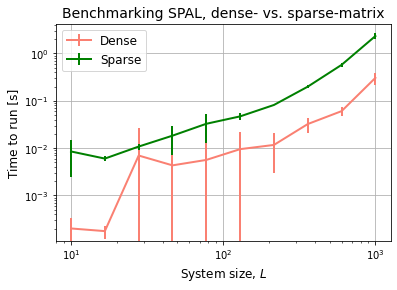

In [3]:

plt.figure()

plt.errorbar(Ls, times[:,0], STD[:,0], xerr=None, label='Dense',
            lw= 2, c='salmon')
plt.errorbar(Ls, times[:,1], STD[:,1], xerr=None, label='Sparse',
            lw=2, c='green')

plt.title('Benchmarking SPAL, dense- vs. sparse-matrix', fontsize=14)
plt.xlabel('System size, $L$', fontsize=12)
plt.ylabel('Time to run [s]', fontsize=12)

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend(fontsize=12)
#plt.show()
plt.savefig('figures/SPAL_bench.png', dpi=500, bbox_inches='tight')

### Does it localize?

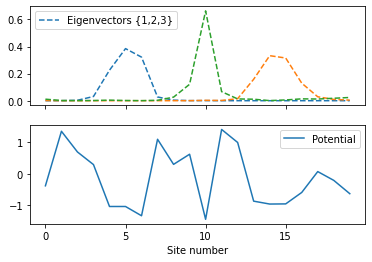

In [8]:
size = 20
H, vals, vecs = make_and_diag_dense_hamiltonian(size=size, disorder=3)

fig, ax = plt.subplots(2,1, sharex=True)

for i in range(3):
    ax[0].plot(range(size), abs(vecs[:,i])**2, ls='--', label='Eigenvector {}'.format(i))

y =  [H[i,i] for i in range(len(H))]
a_BSpline = interpolate.make_interp_spline(range(len(y)), y, k=3)
y_new = a_BSpline(range(size))
ax[1].plot(range(size), y_new, label='Potential')

plt.xlabel('Site number')
plt.xticks(np.arange(0,20,5),np.arange(0,20,5))
ax[0].legend(['Eigenvectors {1,2,3}'],loc='upper left')
ax[1].legend()
plt.show()

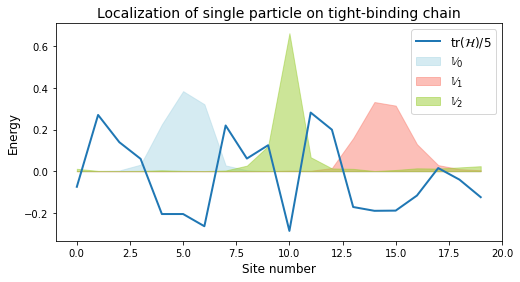

In [9]:
plt.figure(figsize=(8,4))

colors = 'lightblue, salmon, yellowgreen, orange, black, red'.split(', ')

for i, color in zip(range(3), colors):
    plt.fill_between(range(size), 0, abs(vecs[:,i])**2, 
                        label='$\mathbb{V}$'+'$_{}$'.format(i),
                       color=color, 
                     alpha=.5)
    
    #plt.plot(range(size), abs(vecs[:,i])**2, ls='--', label='$\mathbb{V}$'+'$_{}$'.format(i))

y =  [H[i,i] for i in range(len(H))]
a_BSpline = interpolate.make_interp_spline(range(len(y)), y, k=3)
y_new = a_BSpline(range(size))
plt.plot(range(size), y_new/5, label='tr$(\mathcal{H})/5$', lw=2)

plt.title('Localization of single particle on tight-binding chain', size=14)
plt.ylabel('Energy', fontsize=12)
plt.xlabel('Site number', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.xlim(-1, size)

plt.savefig('figures/SPAL_local_wave.png', dpi=500, bbox_inches='tight')


### Can we quantify the degree of localization as to probe the critical disorder strength?

In [10]:
def count_larger_than(lst, threshhold=0.001):
    return sum([i > threshhold for i in lst])

def spreads(eigvecs, num_for_spread=3):
    spread = np.mean([count_larger_than(eigvecs[:,i]**2) for i in range(num_for_spread)])
    return spread/len(eigvecs)

num_seeds, disorders = 100, np.logspace(-4,2,20)


SPREAD, STD = [], []
sizes = np.logspace(1,3,3)
for size in sizes:
    size=int(size)
    spread, std = [], []
    for disorder in disorders:
        spread1 = []
        for seed in range(num_seeds):
            H, vals, vecs = make_and_diag_dense_hamiltonian(size=size, disorder=disorder, seed=seed)
            spread1.append(spreads(vecs))
        spread.append(np.mean(spread1))
        std.append(np.std(spread1))
    
    print(np.shape(disorders), np.shape(spread), np.shape(std))
    SPREAD.append(spread)
    STD.append(std)


(20,) (20,) (20,)
(20,) (20,) (20,)
(20,) (20,) (20,)


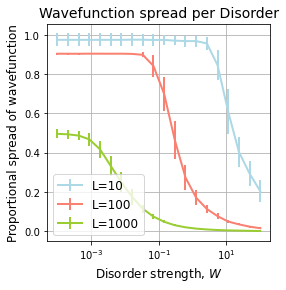

In [16]:
plt.figure(figsize=(4,4))
sizes = np.logspace(1,3,3)
for color, spread, std, size in zip(colors, SPREAD, STD, sizes):
    size = int(size)
    plt.errorbar(disorders, spread, std, xerr=None, 
                 label='L={}'.format(size), 
                 c=color, lw=2)



plt.title('Wavefunction spread per Disorder', fontsize=14)
plt.xlabel('Disorder strength, $W$', fontsize=12)
plt.ylabel('Proportional spread of wavefunction', fontsize=12)

plt.xscale('log')
plt.grid()
plt.legend(fontsize=12, loc='lower left')
#plt.show()
plt.savefig('figures/SPAL_wf_spread.png', dpi=500, bbox_inches='tight')